### testing the importance of distance on instruction priority

In [3]:
%pip install huggingface_hub
%pip install python-dotenv
%pip install huggingface
%pip install datasets
%pip install transformers
%pip install matplotlib
%pip install accelerate
%pip install transformer_lens
%pip install -U "typing_extensions>=4.8.0" "pydantic>=2.0" "wandb>=0.16"
%pip install -U --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 177.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 305.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
No

In [4]:
%pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from dotenv import load_dotenv
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
os.environ["DATASETS_DISABLE_PROGRESS_BAR"] = "1"

load_dotenv()
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

In [2]:
!hf auth login --token {huggingface_token}

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `a3` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `a3`


In [3]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import random
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import gc

In [4]:
#load wiki
ds = load_dataset("wikitext", "wikitext-2-raw-v1")

In [5]:
print(type(ds))
print(ds)

<class 'datasets.dataset_dict.DatasetDict'>
DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [6]:
print(ds["train"][7])

{'text': ' = = Gameplay = = \n'}


In [7]:
def keep_row(example):
    text = example['text']
    if not text:
        return False
    if text == "\n":
        return False
    # if text.startswith("="):
    #     return False
    return True

In [8]:
filtered_wiki = ds.filter(keep_row)

Filter:   0%|          | 0/4358 [00:00<?, ? examples/s]

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [9]:
model_name = "google/gemma-2-9b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
### tokenize dataset
full_text = "\n".join([line for line in filtered_wiki["train"]["text"]])
all_tokens = tokenizer.encode(full_text, add_special_tokens = False)

In [11]:
def get_r_wiki_slice(n_tokens):
    start_idx = random.randint(0, len(all_tokens) - n_tokens - 1)
    return all_tokens[start_idx : start_idx + n_tokens]

In [12]:
# system_prompt = "Your goal is to respond to the user's request while making sure his instructions are fully satistfied. An instruction will appear in the form 'Instruction: <INSTRUCTION>.'\n"
system_prompt = ""
end_question = "\nNow, provide your response based on the previous instructions. \n"

instruction_set = {
    "language": ["Respond in French.", "Respond in German."],
    "first_word": ["Begin your response with the word 'CHERRY'.", "Begin your response with the word 'APPLE'."],
}


In [13]:
def find_token_span(target_ids, full_ids):
    n = len(target_ids)
    for i in range(len(full_ids) - n + 1):
        if full_ids[i : i + n] == target_ids:
            return i, i + n
    return None, None

In [14]:
def construct_single_instr_prompt(instr_text, pos_pct, total_length=2048):
    formatted_instr = f"\n\nInstruction: {instr_text}\n\n"
    
    dummy_messages = [{"role": "user", "content": "DUMMY"}]
    dummy_ids = tokenizer.apply_chat_template(dummy_messages, tokenize=True, add_generation_prompt=True)
    template_overhead = len(dummy_ids) - len(tokenizer.encode("DUMMY", add_special_tokens=False))
    
    instr_tokens = tokenizer.encode(formatted_instr, add_special_tokens=False)
    sys_tokens = tokenizer.encode(system_prompt, add_special_tokens=False)
    end_tokens = tokenizer.encode(end_question, add_special_tokens=False)
    
    fixed_parts_len = len(sys_tokens) + len(instr_tokens) + len(end_tokens) + template_overhead
    filler_budget = total_length - fixed_parts_len
    
    if filler_budget < 0:
        raise ValueError(f"Instructions too long! Overhead is {fixed_parts_len}")

    filler_tokens = get_r_wiki_slice(filler_budget)
    split_idx = int(pos_pct * filler_budget)
    
    user_content = (
        system_prompt + 
        tokenizer.decode(filler_tokens[:split_idx]) + 
        formatted_instr + 
        tokenizer.decode(filler_tokens[split_idx:]) + 
        end_question
    )
    
    messages = [{"role": "user", "content": user_content}]
    input_ids = tokenizer.apply_chat_template(
        messages, 
        tokenize=True, 
        add_generation_prompt=True, 
        return_tensors="pt"
    )

    if input_ids.shape[1] != total_length:
        diff = input_ids.shape[1] - total_length
        if diff > 0:

            input_ids = torch.cat([input_ids[:, :10], input_ids[:, 10+diff:]], dim=1)
        else:
            padding = torch.full((1, abs(diff)), tokenizer.pad_token_id).to(input_ids.device)
            input_ids = torch.cat([input_ids[:, :10], padding, input_ids[:, 10:]], dim=1)

    return input_ids, None

In [15]:
test_ids, _ = construct_single_instr_prompt("Begin with CHERRY", 0.5, 1024)
print(f"Total length: {test_ids.shape[1]}")
print(f"End of prompt tokens: {test_ids[0, -10:].tolist()}")
print(f"End of prompt decoded: '{tokenizer.decode(test_ids[0, -15:])}'")

Total length: 1024
End of prompt tokens: [611, 573, 4509, 12027, 235265, 107, 108, 106, 2516, 108]
End of prompt decoded: ', provide your response based on the previous instructions.<end_of_turn>
<start_of_turn>model
'


In [16]:
cherry_ids = [
    tokenizer.encode(" CHERRY", add_special_tokens=False)[0],
    tokenizer.encode("CHERRY\n", add_special_tokens=False)[0],
    tokenizer.encode("CHERRY ", add_special_tokens=False)[0],
    tokenizer.encode("CHERRY", add_special_tokens=False)[0],
    tokenizer.encode("\nCHERRY", add_special_tokens=False)[0],
]

apple_ids = [
    tokenizer.encode(" APPLE", add_special_tokens=False)[0],
    tokenizer.encode("APPLE\n", add_special_tokens=False)[0],
    tokenizer.encode("APPLE ", add_special_tokens=False)[0],
    tokenizer.encode("APPLE", add_special_tokens=False)[0],
    tokenizer.encode("\nAPPLE", add_special_tokens=False)[0],
]

In [17]:
def batched_position_sweep(model, instr_text, total_length, samples_per_pos=100, batch_size=2):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 21)
    target_token_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    
    results = {round(pct, 2): {"logits": [], "is_correct": []} for pct in pcts}
    # This will now store a LIST of completions for each position
    decoded_completions = {round(pct, 2): [] for pct in pcts}
    
    model.eval()
    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"Processing Position: {pct_key:.2f}")
        
        num_batches = (samples_per_pos + batch_size - 1) // batch_size
        
        # Determine which specific global indices we want to decode (5%)
        num_to_decode = math.ceil(0.05 * samples_per_pos)
        decode_indices = set(random.sample(range(samples_per_pos), num_to_decode))
        
        global_idx = 0 

        for b in tqdm(range(num_batches)):
            batch_list = []
            for _ in range(batch_size):
                if len(batch_list) + b*batch_size < samples_per_pos: # Handle final uneven batch
                    ids, _ = construct_single_instr_prompt(instr_text, pct, total_length)
                    batch_list.append(ids)
            
            batch_tensor = torch.cat(batch_list, dim=0).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensor)
                last_token_logits = outputs.logits[:, -1, :] 
            
            # Logit/Accuracy Data
            cherry_logits = last_token_logits[:, target_token_id].cpu().tolist()
            results[pct_key]["logits"].extend(cherry_logits)
            
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_mask = [p.item() in cherry_ids for p in predictions]
            results[pct_key]["is_correct"].extend(correct_mask)
            

            # decoded_batch = tokenizer.batch_decode(gen_ids[:, total_length:], skip_special_tokens=True)
            # is_correct = ["CHERRY" in resp.upper() for resp in decoded_batch]
            # results[pct_key]["is_correct"].extend(is_correct)

            # --- THE SANITY CHECK DECODE ---
            # We check each item in the current batch to see if its global index is in our 5% set
            for i in range(len(batch_list)):
                if global_idx in decode_indices:
                    with torch.no_grad():
                        # Generate for just this one sequence
                        gen_ids = model.generate(
                            batch_tensor[i:i+1], 
                            max_new_tokens=15, # Increased to see the full context of the failure
                            do_sample=False,
                            pad_token_id=tokenizer.eos_token_id
                        )
                        # Extract and store completion only
                        completion = tokenizer.decode(gen_ids[0, total_length:], skip_special_tokens=True)
                        decoded_completions[pct_key].append(completion)
                
                global_idx += 1
            
            del outputs
            torch.cuda.empty_cache()
            
    return results, decoded_completions

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="eager" 
)

`torch_dtype` is deprecated! Use `dtype` instead!


In [19]:
def plot_dual_results(results, word):
    x = sorted(results.keys())

    token_id = tokenizer.encode(word, add_special_tokens=False)[0]
    # Prepare Data
    logit_means = [np.mean(results[pct][f"logits_{token_id}"]) for pct in x]
    logit_stds = [np.std(results[pct][f"logits_{token_id}"]) for pct in x]
    accuracy = [np.mean(results[pct][f"is_correct_{token_id}"]) for pct in x]
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Logits
    color = 'tab:blue'
    ax1.set_xlabel('Position (0.0=Start, 1.0=End)')
    ax1.set_ylabel(f'Logit Magnitude ({word})', color=color)
    ax1.errorbar(x, logit_means, yerr=logit_stds, fmt='-o', color=color, label='Logit')
    ax1.tick_params(axis='y', labelcolor=color)

    # Plot Accuracy on second axis
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(f'Accuracy (Was {word} Top-1)', color=color)
    ax2.plot(x, accuracy, '-s', color=color, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(-0.1, 1.1) # Accuracy is 0 to 1

    plt.title(f"Instruction Salience:")
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

In [34]:
sweep_data, examples = batched_position_sweep(model, instruction_set["first_word"][0], total_length=6144, samples_per_pos=15)
plot_dual_results(sweep_data)

Processing Position: 0.00


100%|██████████| 8/8 [00:26<00:00,  3.32s/it]


Processing Position: 0.05


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Processing Position: 0.10


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Processing Position: 0.15


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Processing Position: 0.20


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


Processing Position: 0.25


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Processing Position: 0.30


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


Processing Position: 0.35


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Processing Position: 0.40


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Processing Position: 0.45


100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


Processing Position: 0.50


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Processing Position: 0.55


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Processing Position: 0.60


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


Processing Position: 0.65


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


Processing Position: 0.70


100%|██████████| 8/8 [00:27<00:00,  3.45s/it]


Processing Position: 0.75


100%|██████████| 8/8 [00:27<00:00,  3.47s/it]


Processing Position: 0.80


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Processing Position: 0.85


100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


Processing Position: 0.90


100%|██████████| 8/8 [00:27<00:00,  3.41s/it]


Processing Position: 0.95


100%|██████████| 8/8 [00:27<00:00,  3.42s/it]


Processing Position: 1.00


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


TypeError: plot_dual_results() missing 1 required positional argument: 'word'

In [19]:
print(examples)

NameError: name 'examples' is not defined

In [20]:
def construct_multi_instr_prompt(instr_texts, pos_pct, total_length=2048):
    formatted_instr1 = f"\n\nInstruction: {instr_texts[0]}\n\n"
    formatted_instr2 = f"\n\nInstruction: {instr_texts[1]}\n\n"
    dummy_messages = [{"role": "user", "content": "DUMMY"}]
    dummy_ids = tokenizer.apply_chat_template(dummy_messages, tokenize=True, add_generation_prompt=True)
    template_overhead = len(dummy_ids) - len(tokenizer.encode("DUMMY", add_special_tokens=False))
    
    instr1_tokens = tokenizer.encode(formatted_instr1, add_special_tokens=False)
    instr2_tokens = tokenizer.encode(formatted_instr2, add_special_tokens=False)
    sys_tokens = tokenizer.encode(system_prompt, add_special_tokens=False)
    end_tokens = tokenizer.encode(end_question, add_special_tokens=False)
    
    fixed_parts_len = len(sys_tokens) + len(instr1_tokens) + len(instr2_tokens) + len(end_tokens) + template_overhead
    filler_budget = total_length - fixed_parts_len
    
    if filler_budget < 0:
        raise ValueError(f"Instructions too long! Overhead is {fixed_parts_len}")

    filler_tokens = get_r_wiki_slice(filler_budget)
    split_idx = int(pos_pct * filler_budget)
    
    user_content = (
        system_prompt + 
        formatted_instr1 + 
        tokenizer.decode(filler_tokens[:split_idx]) + 
        formatted_instr2 + 
        # tokenizer.decode(filler_tokens[split_idx:]) + 
        end_question
    )
    
    messages = [{"role": "user", "content": user_content}]
    input_ids = tokenizer.apply_chat_template(
        messages, 
        tokenize=True, 
        add_generation_prompt=True, 
        return_tensors="pt"
    )

    if input_ids.shape[1] != total_length:
        diff = input_ids.shape[1] - total_length
        if diff > 0:

            input_ids = torch.cat([input_ids[:, :10], input_ids[:, 10+diff:]], dim=1)
        else:
            padding = torch.full((1, abs(diff)), tokenizer.pad_token_id).to(input_ids.device)
            input_ids = torch.cat([input_ids[:, :10], padding, input_ids[:, 10:]], dim=1)

    return input_ids, None

In [21]:
def batched_position_sweep_multiple(model, instr_texts, total_length, samples_per_pos=100, batch_size=2):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 21)
    cherry_token_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    apple_token_id = tokenizer.encode( " APPLE", add_special_tokens=False)[0]
    results = {round(pct, 2): {f"logits_{cherry_token_id}": [], f"is_correct_{cherry_token_id}": [], f"logits_{apple_token_id}": [], f"is_correct_{apple_token_id}": []} for pct in pcts}
    
    decoded_completions = {round(pct, 2): [] for pct in pcts}
    
    model.eval()
    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"Processing Position: {pct_key:.2f}")
        
        num_batches = (samples_per_pos + batch_size - 1) // batch_size
        
        # Determine which specific global indices we want to decode (5%)
        num_to_decode = math.ceil(0.05 * samples_per_pos)
        decode_indices = set(random.sample(range(samples_per_pos), num_to_decode))
        
        global_idx = 0 

        for b in tqdm(range(num_batches)):
            batch_list = []
            for _ in range(batch_size):
                if len(batch_list) + b*batch_size < samples_per_pos: # Handle final uneven batch
                    ids, _ = construct_multi_instr_prompt(instr_texts, pct, total_length)
                    batch_list.append(ids)
            
            batch_tensor = torch.cat(batch_list, dim=0).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensor)
                last_token_logits = outputs.logits[:, -1, :] 
            
            # Logit/Accuracy Data
            cherry_logits = last_token_logits[:, cherry_token_id].cpu().tolist()
            apple_logits = last_token_logits[:, apple_token_id].cpu().tolist()
            results[pct_key][f"logits_{cherry_token_id}"].extend(cherry_logits)
            results[pct_key][f"logits_{apple_token_id}"].extend(apple_logits)
            
            
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_masks = {f"{cherry_token_id}": [p.item() in cherry_ids for p in predictions],
                             f"{apple_token_id}": [p.item() in apple_ids for p in predictions]}
            results[pct_key][f"is_correct_{cherry_token_id}"].extend(correct_masks[f"{cherry_token_id}"])
            results[pct_key][f"is_correct_{apple_token_id}"].extend(correct_masks[f"{apple_token_id}"])
            

            # decoded_batch = tokenizer.batch_decode(gen_ids[:, total_length:], skip_special_tokens=True)
            # is_correct = ["CHERRY" in resp.upper() for resp in decoded_batch]
            # results[pct_key]["is_correct"].extend(is_correct)

            # --- THE SANITY CHECK DECODE ---
            # We check each item in the current batch to see if its global index is in our 5% set
            for i in range(len(batch_list)):
                if global_idx in decode_indices:
                    with torch.no_grad():
                        # Generate for just this one sequence
                        gen_ids = model.generate(
                            batch_tensor[i:i+1], 
                            max_new_tokens=55, # Increased to see the full context of the failure
                            do_sample=False,
                            pad_token_id=tokenizer.eos_token_id
                        )
                        # Extract and store completion only
                        completion = tokenizer.decode(gen_ids[0, total_length:], skip_special_tokens=True)
                        decoded_completions[pct_key].append(completion)
                
                global_idx += 1
            
            del outputs
            torch.cuda.empty_cache()
            
    return results, decoded_completions

In [22]:
sweep_data, examples = batched_position_sweep_multiple(model, instruction_set["first_word"], total_length=6144, samples_per_pos=15)


Processing Position: 0.00


100%|██████████| 8/8 [00:25<00:00,  3.19s/it]


Processing Position: 0.05


100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


Processing Position: 0.10


100%|██████████| 8/8 [00:28<00:00,  3.51s/it]


Processing Position: 0.15


100%|██████████| 8/8 [00:28<00:00,  3.52s/it]


Processing Position: 0.20


100%|██████████| 8/8 [00:28<00:00,  3.53s/it]


Processing Position: 0.25


100%|██████████| 8/8 [00:28<00:00,  3.54s/it]


Processing Position: 0.30


100%|██████████| 8/8 [00:26<00:00,  3.27s/it]


Processing Position: 0.35


100%|██████████| 8/8 [00:27<00:00,  3.43s/it]


Processing Position: 0.40


100%|██████████| 8/8 [00:27<00:00,  3.48s/it]


Processing Position: 0.45


100%|██████████| 8/8 [00:26<00:00,  3.37s/it]


Processing Position: 0.50


100%|██████████| 8/8 [00:28<00:00,  3.55s/it]


Processing Position: 0.55


100%|██████████| 8/8 [00:28<00:00,  3.56s/it]


Processing Position: 0.60


100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


Processing Position: 0.65


100%|██████████| 8/8 [00:28<00:00,  3.55s/it]


Processing Position: 0.70


100%|██████████| 8/8 [00:27<00:00,  3.39s/it]


Processing Position: 0.75


100%|██████████| 8/8 [00:28<00:00,  3.56s/it]


Processing Position: 0.80


100%|██████████| 8/8 [00:28<00:00,  3.53s/it]


Processing Position: 0.85


100%|██████████| 8/8 [00:26<00:00,  3.35s/it]


Processing Position: 0.90


100%|██████████| 8/8 [00:27<00:00,  3.49s/it]


Processing Position: 0.95


100%|██████████| 8/8 [00:27<00:00,  3.44s/it]


Processing Position: 1.00


100%|██████████| 8/8 [00:28<00:00,  3.58s/it]


{np.float64(0.0): {'logits_4029': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0], 'is_correct_4029': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'logits_140067': [13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25, 13.25], 'is_correct_140067': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]}, np.float64(0.05): {'logits_4029': [1.671875, 0.57421875, -0.4765625, 1.7265625, 0.55859375, 0.85546875, 0.515625, 0.90234375, 2.078125, -0.80078125, 1.6484375, 0.0654296875, 2.015625, 0.97265625, 0.87109375], 'is_correct_4029': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'logits_140067': [14.75, 12.4375, 12.875, 13.625, 12.1875, 13.0625, 13.0625, 12.4375, 12.75, 12.3125, 12.25, 12.6875, 13.625, 13.9375, 12.1875], 'is_correct_140067': [True, True, True, True,

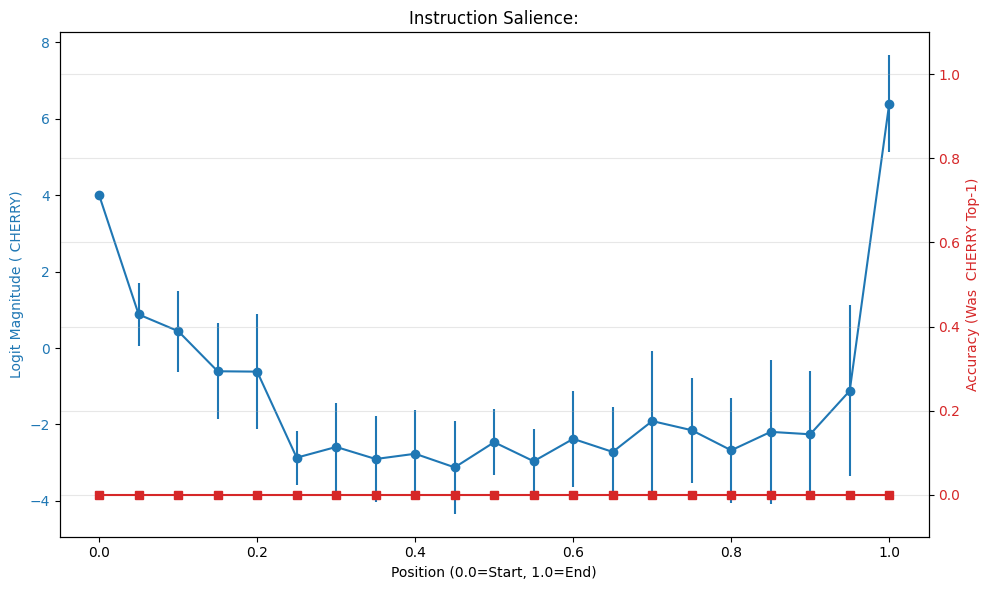

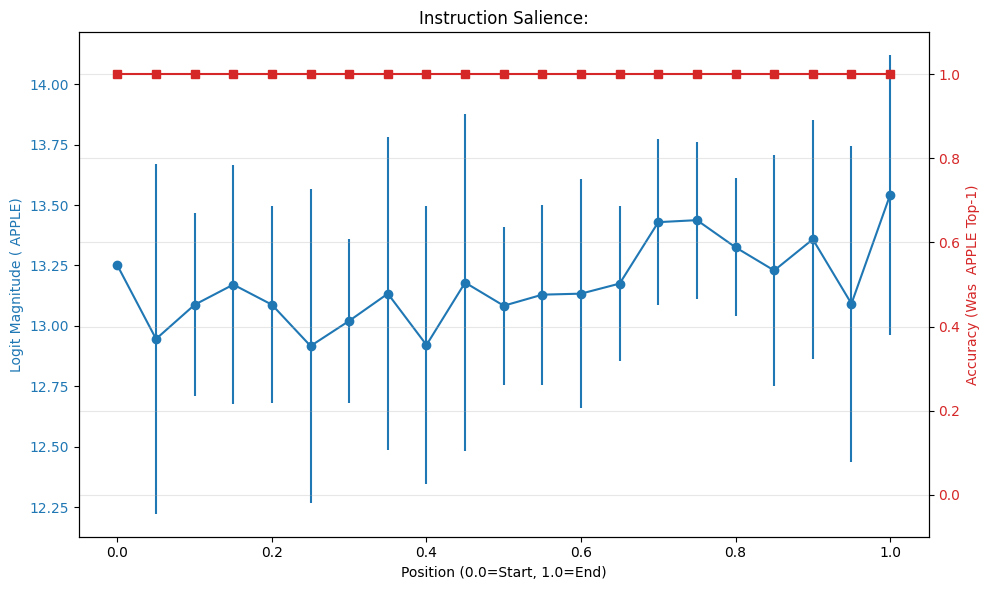

In [24]:
print(sweep_data)
plot_dual_results(sweep_data, " CHERRY")
plot_dual_results(sweep_data, " APPLE")

In [38]:
id = tokenizer.encode("APPLE", add_special_tokens = False)
print(id)

[109248]


In [25]:
print(examples)

{np.float64(0.0): ['APPLE CHERRY. \n'], np.float64(0.05): ["APPLE  Cassini's observations of Jupiter's atmosphere revealed that the dark belts are actually areas of sinking air. This finding challenged previous theories and provided new insights into the complex atmospheric dynamics of the gas giant. \n"], np.float64(0.1): ["APPLE.  It seems you're asking me to continue a story or provide information related to Wilhelm Busch's life and works, particularly focusing on his satirical pieces. \n\nLet me know what you'd like to explore further. For example, are you interested in"], np.float64(0.15): ["APPLE.  The text you provided details the tumultuous period in English history known as the Second Barons' War. It focuses on the actions of Simon de Montfort, a powerful baron who challenged the authority of King Henry III. \n\nMontfort's ambition led him"], np.float64(0.2): ['APPLE  The Merville Battery was a significant German coastal artillery battery located near the town of Merville, Fra

In [22]:
#fixed window experiment
def construct_multi_instr_prompt_window(instr_texts, pos_pct, total_length=2048, window_length = 500):
    formatted_instr1 = f"\n\nInstruction: {instr_texts[0]}\n\n"
    formatted_instr2 = f"\n\nInstruction: {instr_texts[1]}\n\n"
    dummy_messages = [{"role": "user", "content": "DUMMY"}]
    dummy_ids = tokenizer.apply_chat_template(dummy_messages, tokenize=True, add_generation_prompt=True)
    template_overhead = len(dummy_ids) - len(tokenizer.encode("DUMMY", add_special_tokens=False))
    
    instr1_tokens = tokenizer.encode(formatted_instr1, add_special_tokens=False)
    instr2_tokens = tokenizer.encode(formatted_instr2, add_special_tokens=False)
    sys_tokens = tokenizer.encode(system_prompt, add_special_tokens=False)
    end_tokens = tokenizer.encode(end_question, add_special_tokens=False)
    
    fixed_parts_len = len(sys_tokens) + len(instr1_tokens) + len(instr2_tokens) + len(end_tokens) + template_overhead
    filler_budget = total_length - fixed_parts_len
    
    if filler_budget < 0:
        raise ValueError(f"Instructions too long! Overhead is {fixed_parts_len}")

    filler_tokens = get_r_wiki_slice(filler_budget)
    split_idx = int(pos_pct * (filler_budget - (window_length+1)))
    
    user_content = (
        system_prompt + 
        tokenizer.decode(filler_tokens[:split_idx]) + 
        formatted_instr1 + 
        tokenizer.decode(filler_tokens[split_idx:split_idx + window_length]),
        formatted_instr2 + 
        tokenizer.decode(filler_tokens[split_idx + window_length:]) + 
        end_question
    )
    
    messages = [{"role": "user", "content": user_content}]
    input_ids = tokenizer.apply_chat_template(
        messages, 
        tokenize=True, 
        add_generation_prompt=True, 
        return_tensors="pt"
    )

    if input_ids.shape[1] != total_length:
        diff = input_ids.shape[1] - total_length
        if diff > 0:

            input_ids = torch.cat([input_ids[:, :10], input_ids[:, 10+diff:]], dim=1)
        else:
            padding = torch.full((1, abs(diff)), tokenizer.pad_token_id).to(input_ids.device)
            input_ids = torch.cat([input_ids[:, :10], padding, input_ids[:, 10:]], dim=1)

    return input_ids, None


In [23]:
def batched_position_sweep_multiple_window(model, instr_texts, total_length, samples_per_pos=100, window_length=500, batch_size=2):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 21)
    cherry_token_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    apple_token_id = tokenizer.encode( " APPLE", add_special_tokens=False)[0]
    results = {round(pct, 2): {f"logits_{cherry_token_id}": [], f"is_correct_{cherry_token_id}": [], f"logits_{apple_token_id}": [], f"is_correct_{apple_token_id}": []} for pct in pcts}
    
    decoded_completions = {round(pct, 2): [] for pct in pcts}
    
    model.eval()
    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"Processing Position: {pct_key:.2f}")
        
        num_batches = (samples_per_pos + batch_size - 1) // batch_size
        
        # Determine which specific global indices we want to decode (5%)
        num_to_decode = math.ceil(0.05 * samples_per_pos)
        decode_indices = set(random.sample(range(samples_per_pos), num_to_decode))
        
        global_idx = 0 

        for b in tqdm(range(num_batches)):
            batch_list = []
            for _ in range(batch_size):
                if len(batch_list) + b*batch_size < samples_per_pos: # Handle final uneven batch
                    ids, _ = construct_multi_instr_prompt_window(instr_texts, pct, total_length, window_length=window_length)
                    batch_list.append(ids)
            
            batch_tensor = torch.cat(batch_list, dim=0).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensor)
                last_token_logits = outputs.logits[:, -1, :] 
            
            # Logit/Accuracy Data
            cherry_logits = last_token_logits[:, cherry_token_id].cpu().tolist()
            apple_logits = last_token_logits[:, apple_token_id].cpu().tolist()
            results[pct_key][f"logits_{cherry_token_id}"].extend(cherry_logits)
            results[pct_key][f"logits_{apple_token_id}"].extend(apple_logits)
            
            
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_masks = {f"{cherry_token_id}": [p.item() in cherry_ids for p in predictions],
                             f"{apple_token_id}": [p.item() in apple_ids for p in predictions]}
            results[pct_key][f"is_correct_{cherry_token_id}"].extend(correct_masks[f"{cherry_token_id}"])
            results[pct_key][f"is_correct_{apple_token_id}"].extend(correct_masks[f"{apple_token_id}"])
            

            # decoded_batch = tokenizer.batch_decode(gen_ids[:, total_length:], skip_special_tokens=True)
            # is_correct = ["CHERRY" in resp.upper() for resp in decoded_batch]
            # results[pct_key]["is_correct"].extend(is_correct)

            # --- THE SANITY CHECK DECODE ---
            # We check each item in the current batch to see if its global index is in our 5% set
            for i in range(len(batch_list)):
                if global_idx in decode_indices:
                    with torch.no_grad():
                        # Generate for just this one sequence
                        gen_ids = model.generate(
                            batch_tensor[i:i+1], 
                            max_new_tokens=15, # Increased to see the full context of the failure
                            do_sample=False,
                            pad_token_id=tokenizer.eos_token_id
                        )
                        # Extract and store completion only
                        completion = tokenizer.decode(gen_ids[0, total_length:], skip_special_tokens=True)
                        decoded_completions[pct_key].append(completion)
                
                global_idx += 1
            
            del outputs
            torch.cuda.empty_cache()
            
    return results, decoded_completions

Processing Position: 0.00


100%|██████████| 10/10 [00:34<00:00,  3.45s/it]


Processing Position: 0.05


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


Processing Position: 0.10


100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


Processing Position: 0.15


100%|██████████| 10/10 [00:34<00:00,  3.46s/it]


Processing Position: 0.20


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.25


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.30


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.35


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.40


100%|██████████| 10/10 [00:35<00:00,  3.50s/it]


Processing Position: 0.45


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.50


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.55


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.60


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.65


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.70


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.75


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.80


100%|██████████| 10/10 [00:35<00:00,  3.50s/it]


Processing Position: 0.85


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.90


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 0.95


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]


Processing Position: 1.00


100%|██████████| 10/10 [00:34<00:00,  3.50s/it]

{0.0: {'logits_4029': [-5.53125, -2.734375, -5.625, -5.65625, -2.5625, -2.125, -4.0, -3.875, -0.76953125, -4.75, -4.65625, -4.875, -4.90625, -3.453125, -3.546875, -2.125, -4.75, -3.375, -3.203125, -5.40625], 'is_correct_4029': [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False], 'logits_140067': [13.625, 14.125, 12.0625, 12.75, 13.6875, 15.5, 13.4375, 13.625, 13.4375, 13.75, 13.6875, 14.75, 13.6875, 14.125, 12.4375, 13.5625, 13.875, 12.8125, 12.9375, 12.25], 'is_correct_140067': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]}, 0.05: {'logits_4029': [13.625, 11.75, 12.9375, 13.125, 13.1875, 12.75, 12.125, 13.3125, 11.875, 12.3125, 11.0625, 11.8125, 11.75, 12.125, 12.1875, 12.25, 11.8125, 10.9375, 12.0, 13.1875], 'is_correct_4029': [True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True

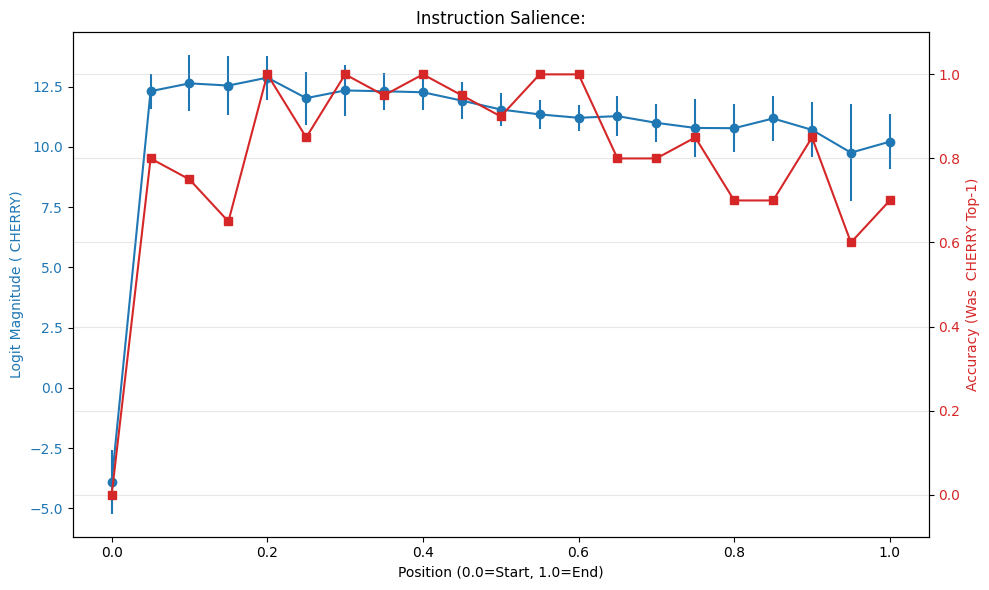

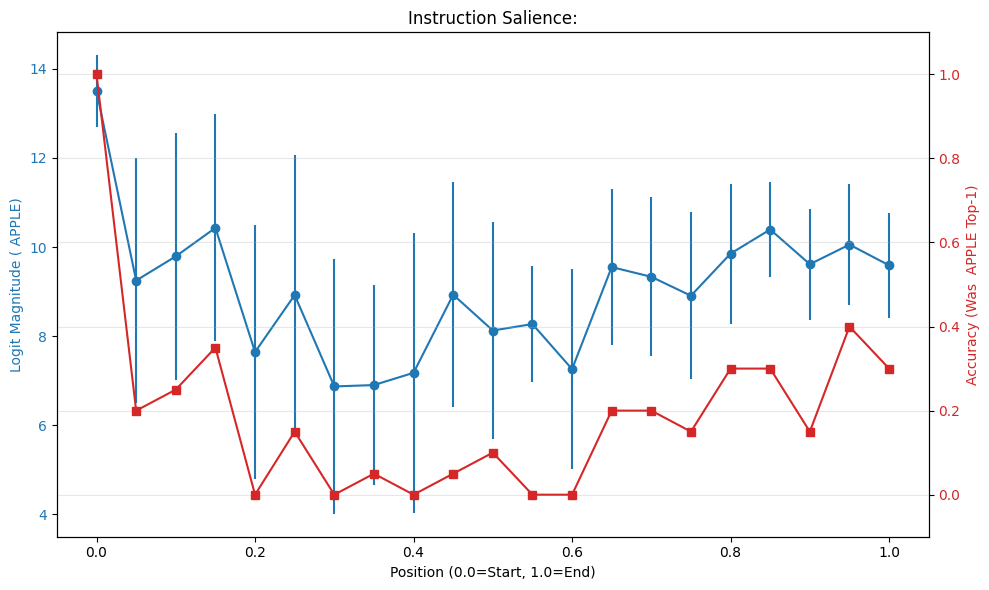

In [49]:
sweep_data, examples = batched_position_sweep_multiple_window(model, instruction_set["first_word"], total_length=6144, window_length=1024 ,samples_per_pos=20)
print(sweep_data)
plot_dual_results(sweep_data, " CHERRY")
plot_dual_results(sweep_data, " APPLE")

In [19]:
from transformer_lens import HookedTransformer

In [20]:
model = HookedTransformer.from_pretrained(
    model_name,
    fold_ln=True,
    center_writing_weights=False,
    center_unembed=False,
    torch_dtype=torch.bfloat16,
)
model = model.to("cuda") 

`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model google/gemma-2-9b-it into HookedTransformer
Moving model to device:  cuda


In [ ]:
def get_logit_lens_stats(tokens, target_id_a, target_id_b):
    logits, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    accumulated_resid = cache.accumulated_resid(pos=-1, incl_mid=False) 
    

    layer_logits = model.unembed(model.ln_final(accumulated_resid))
    
    logit_diffs = layer_logits[:, target_id_a] - layer_logits[:, target_id_b]
    
    return logit_diffs.cpu().numpy()


cherry_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
apple_id = tokenizer.encode(" APPLE", add_special_tokens=False)[0]

diff_success = get_logit_lens_stats(clean_tokens, cherry_id, apple_id)
diff_failure = get_logit_lens_stats(corrupted_tokens, cherry_id, apple_id)

# PLOT: Layer (X-axis) vs Logit Diff (Y-axis)

In [23]:
import gc
import torch
import numpy as np
from tqdm import tqdm

def batched_position_sweep_multiple_with_dla(model, instr_texts, total_length, samples_per_pos=20):
    device = next(model.parameters()).device
    pcts = np.linspace(0.0, 1.0, 21)
    
    cherry_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
    apple_id = tokenizer.encode(" APPLE", add_special_tokens=False)[0]
    
    # Pre-calculate the logit-diff direction and keep it on GPU
    logit_diff_direction = (model.W_U[:, cherry_id] - model.W_U[:, apple_id]).detach().to(device)

    results = {round(pct, 2): {"logits_cherry": [], "logits_apple": []} for pct in pcts}
    dla_results = {round(pct, 2): torch.zeros(model.cfg.n_layers, model.cfg.n_heads).to(device) for pct in pcts}
    
    model.eval()

    for pct in pcts:
        pct_key = round(pct, 2)
        print(f"\nProcessing Position: {pct_key:.2f}")

        for s in tqdm(range(samples_per_pos)):
            # --- STEP 1: PRE-FLUSH MEMORY ---
            gc.collect()
            torch.cuda.empty_cache()
            
            # Generate one sample (Batch Size 1 is mandatory for 6k tokens)
            ids, _ = construct_multi_instr_prompt(instr_texts, pct, total_length)
            batch_tensor = ids.to(device)
            
            # Storage for this specific sample
            last_token_z_storage = {}

            # Hook that offloads to CPU immediately
            def z_hook(value, hook):
                # .cpu() is the magic here. It moves the data off the GPU immediately.
                last_token_z_storage[hook.name] = value[:, -1, :, :].detach().cpu()

            hook_names = [f"blocks.{l}.attn.hook_z" for l in range(model.cfg.n_layers)]

            # --- STEP 2: INFERENCE MODE ---
            with torch.inference_mode(): # Better than no_grad for memory
                logits = model.run_with_hooks(
                    batch_tensor,
                    fwd_hooks=[(name, z_hook) for name in hook_names]
                )
            
            # Save basic logit results
            last_token_logits = logits[0, -1, :] 
            results[pct_key]["logits_cherry"].append(last_token_logits[cherry_id].item())
            results[pct_key]["logits_apple"].append(last_token_logits[apple_id].item())

            # --- STEP 3: LAYER-BY-LAYER DLA ---
            # We do this one layer at a time to keep GPU memory usage at a minimum
            for layer in range(model.cfg.n_layers):
                # Bring z back from CPU to GPU just for this layer's calculation
                z = last_token_z_storage[f"blocks.{layer}.attn.hook_z"].to(device)
                
                # model.W_O shape is [layer, head, d_head, d_model]
                W_O = model.blocks[layer].attn.W_O
                
                # Project z to d_model space
                head_outputs = torch.einsum("bhd, hdm -> bhm", z, W_O)
                
                # Apply Final LN (Essential for Gemma-2)
                head_outputs_ln = model.ln_final(head_outputs)
                
                # Dot product with logit-diff direction [batch, head]
                attribution = torch.einsum("bhm, m -> bh", head_outputs_ln, logit_diff_direction)
                
                # Add to total (average later)
                dla_results[pct_key][layer] += attribution.mean(dim=0) / samples_per_pos

                # Cleanup layer-specific tensors immediately
                del z, head_outputs, head_outputs_ln, attribution

            # --- STEP 4: POST-FLUSH ---
            # Explicitly delete everything huge before the next sample
            del logits, batch_tensor, last_token_z_storage

            
    return results, dla_results

In [27]:
results, dla_results = batched_position_sweep_multiple_with_dla(hmodel, instruction_set["first_word"], total_length=6144 ,samples_per_pos=20)
print(sweep_data)



Processing Position: 0.00


100%|██████████| 20/20 [00:59<00:00,  2.98s/it]



Processing Position: 0.05


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]



Processing Position: 0.10


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]



Processing Position: 0.15


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]



Processing Position: 0.20


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]



Processing Position: 0.25


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]



Processing Position: 0.30


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.35


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.40


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]



Processing Position: 0.45


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.50


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.55


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.60


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]



Processing Position: 0.65


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.70


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]



Processing Position: 0.75


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.80


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.85


100%|██████████| 20/20 [01:00<00:00,  3.03s/it]



Processing Position: 0.90


100%|██████████| 20/20 [01:00<00:00,  3.00s/it]



Processing Position: 0.95


100%|██████████| 20/20 [00:59<00:00,  3.00s/it]



Processing Position: 1.00


100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


NameError: name 'sweep_data' is not defined

In [50]:
import plotly.express as px
import numpy as np

pcts = [0.0, 0.2, 0.4, 0.6, 0.8,1.0]

data = []
for pct in pcts:
    mat = dla_results[pct].cpu().detach().numpy()
    for layer in range(mat.shape[0]):
        for head in range(mat.shape[1]):
            data.append({
                "pct": pct,
                "Layer": layer,
                "Head": head,
                "Attribution": mat[layer, head]
            })

fig = px.imshow(
    np.stack([dla_results[p].cpu().detach().numpy() for p in pcts]),
    facet_col=0,
    labels=dict(x="Head", y="Layer", color="Attribution"),
)

fig.show()


In [ ]:
# 1. Get the tokens for your 1.0 (Recency) prompt
# 2. Get the embeddings for the last token position
embeddings = model.W_E[input_ids[0, -1]] # [d_model]

# 3. Project them through the Final LN and Unembed
def get_logit_score(vec):
    # Gemma final LN and Unembed
    logits = model.unembed(model.ln_final(vec))
    return (logits[cherry_token_id] - logits[apple_token_id]).item()

print(f"Embedding-only Logit Diff: {get_logit_score(embeddings):.2f}")

In [21]:
# get 1 clean and one corrupted to figure out the flip mechanic.
#pct 0.25 vs 0.6
clean_ids, _ = construct_multi_instr_prompt(instruction_set["first_word"], 0.25, total_length=6144)
flip_ids, _ = construct_multi_instr_prompt(instruction_set["first_word"], 0.65, total_length=6144)

In [22]:
print(clean_ids)
print(clean_ids[0])
clean_ids_decoded = tokenizer.decode(clean_ids[0], add_special_tokens=False)
flip_ids_decoded = tokenizer.decode(flip_ids[0], add_special_tokens=False)
print(clean_ids_decoded)


tensor([[   2,  106, 1645,  ...,  106, 2516,  108]])
tensor([   2,  106, 1645,  ...,  106, 2516,  108])
<bos><start_of_turn>user
Instruction: Begin your response with<pad><pad><pad> the word 'CHERRY'.

 now be extinct in mainland Britain , surviving in the Channel Islands . 

 = = = Invasive mole crickets , and their biological control = = = 

 Invasive species are those that cause harm in their newly occupied area , where biological control may be attempted . The first @-@ detected invasive mole cricket species was Neoscapteriscus didactylus , a South American species reported as a pest in St. Vincent , West Indies as early as 1837 ; by 1900 , it was a major pest of agriculture in Puerto Rico . It had probably slowly expanded its range northwards , island by island , from South America . The only biological control program against N. didactylus was in Puerto Rico , and it succeeded in establishing the parasitoid wasp Larra bicolor from Amazonian Brazil . In 2001 , N. didactylus in Pue

In [52]:
clean_id_list = clean_ids[0].cpu().detach().numpy().tolist()
flip_id_list= flip_ids[0].cpu().detach().numpy().tolist()
import json
with open('clean_id.json', 'w') as f:
    json.dump(clean_id_list, f, indent=4) # Using indent for pretty printing
with open('flip_id.json', 'w') as f:
    json.dump(flip_id_list, f, indent=4)

In [23]:
print(flip_ids_decoded)

<bos><start_of_turn>user
Instruction: Begin your response with<pad><pad><pad> the word 'CHERRY'.

 the Fourth Dynasty and continued to be so during the Sixth Dynasty and later , in the Middle Kingdom period ( c . 2055 BCE – c . 1650 BCE ) . 

 Djedkare probably also exploited gold mines in the Eastern Desert and in Nubia : indeed , the earliest mention of the " land of gold " – an Ancient Egyptian term for Nubia – is found in an inscription from the mortuary temple of Djedkare Isesi . 

 = = = = Trade relations = = = = 

 Egypt entertained continuing trade relations with the Levant during Djedkare 's reign , possibly as far north as Anatolia . A gold cylinder seal bearing the serekh of Djedkare Isesi together with the cartouche of Menkauhor Kaiu is now on display at the Museum of Fine Arts , Boston . The seal , whose gold may originate from the Pactolus river valley in western Anatolia , could attest to wide ranging trade @-@ contacts during the later Fifth Dynasty , but its provenance

In [29]:
cherry_id = tokenizer.encode(" CHERRY", add_special_tokens=False)[0]
apple_id = tokenizer.encode(" APPLE", add_special_tokens=False)[0]

In [30]:
device = next(model.parameters()).device
n_layers = model.cfg.n_layers

# ---- 0) Pick the correct "final residual" hook name robustly ----
# Most TLens models: final residual stream right after last block is:
#   f"blocks.{n_layers-1}.hook_resid_post"
# Some configs might expose a global final hook, but don't assume.
candidate_final = [
    "hook_final_resid_post",
    f"blocks.{n_layers-1}.hook_resid_post",
]
hook_names = set(model.hook_dict.keys())
final_hook_name = None
for name in candidate_final:
    if name in hook_names:
        final_hook_name = name
        break
if final_hook_name is None:
    # Fall back to something that always exists: last block resid_post
    final_hook_name = f"blocks.{n_layers-1}.hook_resid_post"
    if final_hook_name not in hook_names:
        raise KeyError(
            "Couldn't find a usable final residual hook. "
            "Print available hooks via: list(model.hook_dict.keys())"
        )

# ---- 1) Precompute clean resid_pre last-token for every layer WITHOUT caching the whole run ----
clean_resid_pre_last = [None] * n_layers

def make_capture_clean_resid_pre(layer: int):
    name = f"blocks.{layer}.hook_resid_pre"
    def _capture(act, hook):
        # act: [batch, pos, d_model]
        # store ONLY [d_model] for last token, move to CPU to save VRAM
        clean_resid_pre_last[layer] = act[0, -1].detach().clone().to("cpu")
        return act
    return (name, _capture)

clean_capture_hooks = [make_capture_clean_resid_pre(l) for l in range(n_layers)]

with torch.no_grad(), torch.autocast("cuda", dtype=torch.bfloat16):
    # return_type=None prevents returning giant logits
    _ = model.run_with_hooks(
        clean_ids,
        fwd_hooks=clean_capture_hooks,
        return_type=None
    )

if any(x is None for x in clean_resid_pre_last):
    missing = [i for i,x in enumerate(clean_resid_pre_last) if x is None]
    raise RuntimeError(f"Failed to capture clean resid_pre for layers: {missing}")

# ---- 2) Prepare unembed pieces once (on GPU) ----
# W_U: [d_model, vocab], b_U: [vocab]
W_U = model.W_U.detach()
b_U = model.b_U.detach() if hasattr(model, "b_U") and model.b_U is not None else None

two_ids = torch.tensor([cherry_id, apple_id], device=device, dtype=torch.long)
W_slice = W_U.index_select(dim=1, index=two_ids)              # [d_model, 2]
b_slice = b_U.index_select(dim=0, index=two_ids) if b_U is not None else None  # [2] or None

def logit_diff_from_final_resid_last(resid_last_1d: torch.Tensor) -> float:
    """
    resid_last_1d: [d_model] on GPU
    Computes (logit[cherry] - logit[apple]) without ever forming full vocab logits.
    """
    # Important: ensure it's truly 1D
    if resid_last_1d.ndim != 1:
        resid_last_1d = resid_last_1d.view(-1)

    # ln_final expects [d_model] or [batch,pos,d_model]; 1D is fine in TLens
    resid_ln = model.ln_final(resid_last_1d)

    # [d_model] @ [d_model, 2] -> [2]
    logits_2 = resid_ln @ W_slice
    if b_slice is not None:
        logits_2 = logits_2 + b_slice

    return (logits_2[0] - logits_2[1]).item()

# ---- 3) Layerwise patching: patch resid_pre at LAST TOKEN only, then read final resid_post LAST TOKEN ----
patching_results = []

for layer in range(n_layers):
    clean_vec_cpu = clean_resid_pre_last[layer]               # [d_model] on CPU
    clean_vec_gpu = clean_vec_cpu.to(device, non_blocking=True)

    def make_patch_last_token_resid_pre(clean_vec_gpu: torch.Tensor):
        def _patch(act, hook):
            # act: [batch, pos, d_model]
            act[0, -1] = clean_vec_gpu
            return act
        return _patch

    # capture container (avoid Python scoping gotchas)
    captured = {"resid_last": None}

    def capture_final_resid_last_token(act, hook):
        # act: [batch, pos, d_model]
        captured["resid_last"] = act[0, -1].detach().clone()   # keep on GPU
        return act

    fwd_hooks = [
        (f"blocks.{layer}.hook_resid_pre", make_patch_last_token_resid_pre(clean_vec_gpu)),
        (final_hook_name, capture_final_resid_last_token),
    ]

    with torch.no_grad(), torch.autocast("cuda", dtype=torch.bfloat16):
        _ = model.run_with_hooks(
            flip_ids,
            fwd_hooks=fwd_hooks,
            return_type=None
        )

    resid_last = captured["resid_last"]
    if resid_last is None:
        raise RuntimeError(f"Did not capture final residual at {final_hook_name}. Check hook names.")

    score = logit_diff_from_final_resid_last(resid_last)
    patching_results.append(score)

    # per-iter cleanup
    del clean_vec_gpu, resid_last
    torch.cuda.empty_cache()

patching_results


[-1.125,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.25,
 -1.125,
 -1.125,
 -0.875,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.125,
 -1.125,
 -1.0,
 -1.125,
 -1.125,
 -1.125,
 -0.75,
 -1.0,
 0.25,
 0.75,
 0.625,
 0.625,
 0.6875,
 0.625,
 1.125,
 1.25,
 2.8125,
 2.6875,
 4.125,
 4.625]

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_patching_results(patching_results, clean_baseline, corrupted_baseline):
    """
    patching_results: List of logit differences from your patching loop
    clean_baseline: Logit diff of the 'Clean' prompt (Primacy wins)
    corrupted_baseline: Logit diff of the 'Corrupted' prompt (Recency wins)
    """
    layers = np.arange(len(patching_results))
    
    plt.figure(figsize=(12, 6))
    
    # 1. Plot the patching line
    plt.plot(layers, patching_results, marker='o', color='black', label='Patched Residual Stream', linewidth=2)
    
    # 2. Plot the baselines (horizontal lines)
    plt.axhline(y=clean_baseline, color='green', linestyle='--', label='Clean Baseline (CHERRY Wins)', alpha=0.7)
    plt.axhline(y=corrupted_baseline, color='red', linestyle='--', label='Corrupted Baseline (APPLE Wins)', alpha=0.7)
    
    # 3. Add a "Decision Threshold" line at 0
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

    # 4. Formatting to make it look professional
    plt.title("Activation Patching: Locating the Instruction Priority Switch", fontsize=14)
    plt.xlabel("Layer where Residual Stream was Patched", fontsize=12)
    plt.ylabel("Logit Difference (CHERRY - APPLE)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Identify the jump point for the write-up
    jump_layer = np.argmax(np.diff(patching_results))
    # plt.annotate(f'Major Jump (Layer {jump_layer})', 
    #              xy=(jump_layer, patching_results[jump_layer]), 
    #              xytext=(jump_layer-5, patching_results[jump_layer]+5),
    #              arrowprops=dict(facecolor='black', shrink=0.05))

    plt.show()


In [34]:
def compute_logit_diff_from_ids(input_ids: torch.Tensor) -> float:
    """
    Runs the model once (no logits returned), captures final resid_post for the LAST token,
    and computes (cherry - apple) logit diff from that.
    """
    captured = {"resid_last": None}

    def _capture_final_resid_last(act, hook):
        # act: [batch, pos, d_model]
        captured["resid_last"] = act[0, -1].detach().clone()
        return act

    with torch.no_grad(), torch.autocast("cuda", dtype=torch.bfloat16):
        _ = model.run_with_hooks(
            input_ids,
            fwd_hooks=[(final_hook_name, _capture_final_resid_last)],
            return_type=None,
        )

    resid_last = captured["resid_last"]
    if resid_last is None:
        raise RuntimeError(f"Did not capture final residual at {final_hook_name}. Check hook names.")
    return logit_diff_from_final_resid_last(resid_last)
clean_baseline = compute_logit_diff_from_ids(clean_ids)
flip_baseline  = compute_logit_diff_from_ids(flip_ids)
print(clean_baseline,flip_baseline)

4.375 -1.125


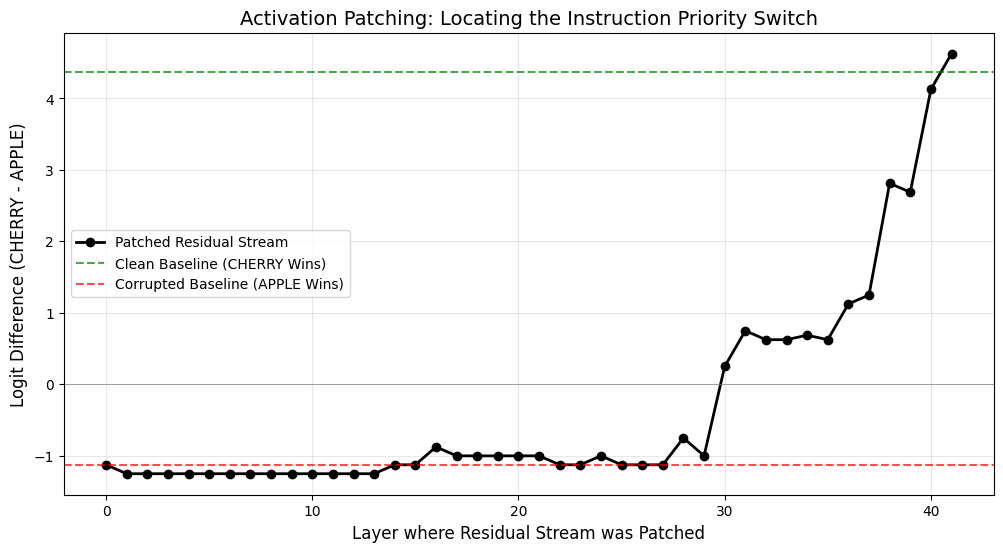

In [48]:
plot_patching_results(patching_results, clean_baseline,flip_baseline)

In [45]:
# ---- 0) Configuration ----
for target_layer in range(15,42):
    # target_layer = 29 
    n_heads = model.cfg.n_heads
    head_patching_results = []

    clean_z_storage = None
    def capture_z(act, hook):
        global clean_z_storage
        # Take last token: [head, d_head]
        clean_z_storage = act[0, -1].detach().clone().to("cpu")
        return act

    with torch.no_grad():
        model.run_with_hooks(
            clean_ids,
            fwd_hooks=[(f"blocks.{target_layer}.attn.hook_z", capture_z)],
            return_type=None
        )

    # ---- 2) Iterate and Patch Each Head's 'z' ----
    for head_idx in tqdm(range(n_heads)):
        # Bring clean z for this head back to GPU
        clean_z_vec = clean_z_storage[head_idx].to(device)

        def patch_specific_z(act, hook):
            # act: [batch, pos, head, d_head]
            act[0, -1, head_idx] = clean_z_vec
            return act

        # Container for the final logit result
        captured = {"resid_last": None}
        def capture_final_resid(act, hook):
            captured["resid_last"] = act[0, -1].detach().clone()
            return act

        fwd_hooks = [
            (f"blocks.{target_layer}.attn.hook_z", patch_specific_z),
            (final_hook_name, capture_final_resid),
        ]

        with torch.no_grad():
            model.run_with_hooks(
                flip_ids, # Corrupted run where APPLE wins
                fwd_hooks=fwd_hooks,
                return_type=None
            )

        score = logit_diff_from_final_resid_last(captured["resid_last"])
        head_patching_results.append(score)
        
        # Cleanup
        del clean_z_vec
        torch.cuda.empty_cache()

    # ---- 3) Plot ----
    import plotly.express as px
    fig = px.bar(x=range(n_heads), y=head_patching_results, 
                title=f"Head-wise Patching (hook_z) at Layer {target_layer}",
                labels={"x": "Head Index", "y": "Logit Difference (CHERRY - APPLE)"})
    fig.show()

100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:45<00:00,  2.81s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.81s/it]


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.80s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


100%|██████████| 16/16 [00:44<00:00,  2.79s/it]


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


100%|██████████| 16/16 [00:44<00:00,  2.77s/it]


100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


100%|██████████| 16/16 [00:44<00:00,  2.78s/it]


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


100%|██████████| 16/16 [00:43<00:00,  2.74s/it]


In [ ]:
# ---- 0) Configuration ----
for target_layer in range(15,42):
    # This is where we store the 'Good' MLP activation
    clean_mlp_storage = None 

    # ---- 1) Capture the 'Clean' MLP Output ----
    def capture_mlp_hook(value, hook):
        # value shape: [batch, pos, d_model]
        # We only save the last token position [-1, :]
        global clean_mlp_storage
        clean_mlp_storage = value[0, -1, :].detach().clone().to("cpu")
        return value

    with torch.no_grad():
        model.run_with_hooks(
            clean_ids, # The prompt where CHERRY wins
            fwd_hooks=[(f"blocks.{target_layer}.hook_mlp_out", capture_mlp_hook)],
            return_type=None
        )

    # ---- 2) Patch the 'Corrupted' MLP Output ----
    # Bring the clean version back to the GPU
    clean_mlp_vec = clean_mlp_storage.to(device)

    def patch_mlp_hook(value, hook):
        # We replace the 'Bad' last token activation with our 'Good' one
        value[0, -1, :] = clean_mlp_vec
        return value

    # Container for the result
    captured = {"resid_last": None}
    def capture_final_resid(act, hook):
        captured["resid_last"] = act[0, -1].detach().clone()
        return act

    fwd_hooks = [
        (f"blocks.{target_layer}.hook_mlp_out", patch_mlp_hook),
        (final_hook_name, capture_final_resid),
    ]

    with torch.no_grad():
        model.run_with_hooks(
            flip_ids, # The prompt where APPLE wins
            fwd_hooks=fwd_hooks,
            return_type=None
        )

    # ---- 3) Measure the Result ----
    mlp_patch_score = logit_diff_from_final_resid_last(captured["resid_last"])

    print(f"Original Corrupted Logit Diff: {flip_baseline:.2f}")
    print(f"Logit Diff after patching MLP {target_layer}: {mlp_patch_score:.2f}")

Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 15: -1.12
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 16: -1.25
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 17: -1.12
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 18: -1.12
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 19: -1.25
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 20: -1.00
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 21: -1.12
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 22: -1.38
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 23: -1.12
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 24: -1.38
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 25: -1.12
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 26: -1.00
Original Corrupted Logit Diff: -1.12
Logit Diff after patching MLP 27: -1.50

KeyError: 'blocks.42.hook_mlp_out'